<a href="https://colab.research.google.com/github/plue1011/GNN/blob/master/pfn2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 課題1

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [0]:
def ReLU(x):
    return np.maximum(0, x)

# ReLU(np.array([1,-1,3]))
# array([1, 0, 3])

特徴ベクトル $ \boldsymbol{x}_{v}^{(t)} \in \mathbb{R}^D $, \\
特徴行列 $ F^{(t)} = \{\boldsymbol{x}_{v}^{(t)}\}_{v \in V} \in \mathbb{R}^{D \times |V|} $

(集約1): $ \boldsymbol{a}_{v}^{(t)} = \sum_{w:(w, v) \in E} \boldsymbol{x}_{w}^{(t)} $ \\
(集約2): $ \boldsymbol{x}_{v}^{t+1} = f(W \cdot \boldsymbol{a}_{v}^{(t)}) $

In [0]:
class Graph:
    def __init__(self, A_input):
        self.A = A_input  # 隣接行列
        self.V = self.A.shape[0]  # 頂点数
        self.T = 2  # 集約回数

    # 集約関数
    def Aggregate(self, W):
        D = W.shape[0]  # パラメータの次元
        F = np.zeros((D, self.V))  # D☓Vのゼロ行列(特徴行列)
        F[0] = 1  # 各頂点の特徴ベクトルの最初の要素を1に初期化

        for i in range(self.T):
            a = F @ self.A
            F = ReLU(W @ a)

        return F @ np.ones((self.V, 1))

In [87]:
A = np.array([[0, 1, 0, 0],
              [1, 0, 1, 1],
              [0, 1, 0, 1],
              [0, 1, 1, 0]])
G = Graph(A)
W1 = np.ones((8, 8))
W2 = np.triu(np.ones((8, 8)))
Vec1 = G.Aggregate(W1)
Vec2 = G.Aggregate(W2)
F0 = np.zeros((8, 4))
F0[0] = 1

print("test")
print(Vec1)
print(Vec2)

test
[[144.]
 [144.]
 [144.]
 [144.]
 [144.]
 [144.]
 [144.]
 [144.]]
[[18.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


# 課題2

問題概要：グラフを入力した場合にそのグラフのラベルを予測する。  
e.g.)化学構造を入力したら、有毒か否かを判定する。

$ A \in \mathbb{R}^D $  
$ b \in \mathbb{R} $  
$ \theta = \{ W, A, b \} :$ 分類器のパラメータ集合  
$ s = A \cdot {\boldsymbol h}_G + b $  
$ p = {\rm Sigmoid}(s) = 1 / (1 + \exp(-s)) $  
$ L = L(G, y, ; \theta) = -y\log{p} - (1-y)\log{(1-p)} $: グラフ$G$に対する正解ラベルを$y \in \{0, 1\}$とするとき、予測に対するbinary cross-entropy損失関数


In [0]:
# sigmoid関数
def sigmoid(s):
    return 1 / (1 + np.exp(-s))

In [0]:
# cross-entropy損失関数
# オーバーフロー対策
def binary_cross_entropy(s, y):
    if s >= 35:
        return y * np.log(1 + np.exp(-s)) + (1 - y) * s
    elif s <= -35: 
        return y * (-s) + (1 - y) * np.log(1 + np.exp(s))
    else:
        return y * np.log(1 + np.exp(-s)) + (1 - y) * np.log(1 + np.exp(s))

In [0]:
# 分類器
class Classifier:
    def __init__(self):
        self.D = 8  # Wの次元数
        self.alpha = 0.0001  # 学習率
        self.epsilon = 0.001  # 微分摂動

        # パラメータの初期値
        self.W = np.random.normal(0, 0.4, (self.D, self.D))
        self.A = np.random.normal(0, 0.4, (self.D, 1))
        self.b = 0

    # 損失計算
    def calculation_loss(self, G, y):
        h_G = G.Aggregate(self.W)
        s = self.A.T @ h_G + self.b
        return binary_cross_entropy(s, y)

    # 勾配計算
    def calculation_grad(self, G, y):
        grad_W = np.zeros((self.D, self.D))
        grad_A = np.zeros((self.D, 1))
        grad_b = 0

        now_loss = self.calculation_loss(G, y)

        for i in range(self.D):
            for j in range(self.D):
                self.W[i][j] += self.epsilon
                grad_W[i][j] = (self.calculation_loss(G, y) - now_loss) / self.epsilon
                self.W[i][j] -= self.epsilon

        for i in range(self.D):
            self.A[i] += self.epsilon
            grad_A[i] = (self.calculation_loss(G, y) - now_loss) / self.epsilon
            self.A[i] -= self.epsilon

        self.b += self.epsilon
        grad_b = (self.calculation_loss(G, y) - now_loss) / self.epsilon
        self.b -= self.epsilon

        return grad_W, grad_A, grad_b

label 0
A
 [[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 1 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]



h_G
 [[13.16701984]
 [ 0.        ]
 [ 0.        ]
 [ 0.71826697]
 [ 6.78530065]
 [ 0.        ]
 [ 9.3669258 ]
 [11.59868524]]
label 1
A
 [[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 1 1 0 0 0]
 [1 1 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0]]



h_G
 [[53.16882853]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


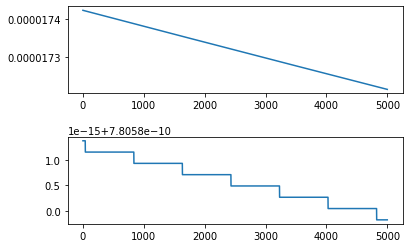

In [135]:
path = "/content/drive/My Drive/study/GNN/scratch/datasets/train/"
data_ids = ["21", "55"]  # 今回使うグラフデータ

plt.subplots_adjust(wspace=0.5, hspace=0.5)

for pos, data_id in enumerate(data_ids):
    graph_name = path + data_id + "_graph.txt"
    label_name = path + data_id + "_label.txt"

    # グラフ読み込み
    with open(graph_name, "r") as f:
        A = [l.strip().split(" ") for l in f.readlines()][1:]
        A = [*map(lambda l: [int(n) for n in l], A)]

    # ラベル読み込み
    with open(label_name, "r") as f:
        label = int(f.readlines()[0].strip())

    A = np.array(A)
    G = Graph(A)

    print("label", label)
    print("A\n", A)

    clf = Classifier()

    loss = clf.calculation_loss(G, label)

    # 損失を保存
    loss_data = [loss]

    for i in tqdm(range(0, 5000)):
        grad_W, grad_A, grad_b = clf.calculation_grad(G, label)
        clf.W = clf.W - clf.alpha * grad_W
        clf.A = clf.A - clf.alpha * grad_A
        clf.b = clf.b - clf.alpha * grad_b

        loss_data.append(float(clf.calculation_loss(G, label)))

    print("h_G\n", G.Aggregate(clf.W))

    plt.subplot(2, 1, pos+1)
    plt.plot(list(range(0, len(loss_data))), loss_data)

plt.show()

# 課題3